In [1]:
# load packages
from __future__ import division, print_function
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Loading the intrinsic matrix
K = np.array([[2759.48 , 0, 1520.69 , 0, 2764.16 , 1006.81 , 0, 0, 1]]).reshape(3, 3)

In [3]:
#calculating the inverse of K for estimating Essential Matrix
K_inv = np.linalg.inv(K)

In [4]:
img1 = cv2.imread("../stereo/0021.jpg")
img2 = cv2.imread("../stereo/0022.jpg")


<Figure size 432x288 with 0 Axes>

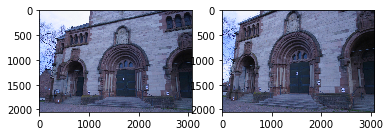

In [5]:

plt.figure()
#converting BGR to RGB for plotting
disp1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
disp2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1,2) 
ax[0].imshow(disp1)
ax[1].imshow(disp2)


In [6]:
#gray scale conversion for detecting keypoints

gray1= cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2= cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

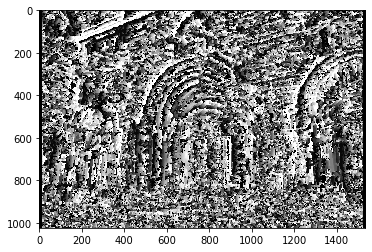

In [7]:
#estimation of disparity map
gray_down1 = cv2.pyrDown(gray1)
gray_down2 = cv2.pyrDown(gray2)
stereo1 = cv2.StereoSGBM_create(
    minDisparity = -16,
    numDisparities = 32,
    blockSize=9,
    speckleWindowSize=50,
    speckleRange = 32,
    disp12MaxDiff = 10,
)
disparity1 = stereo1.compute(gray_down1,gray_down2).astype(np.float32)/16.0
plt.imshow(disparity1,'gray')


plt.show()


matches: 732


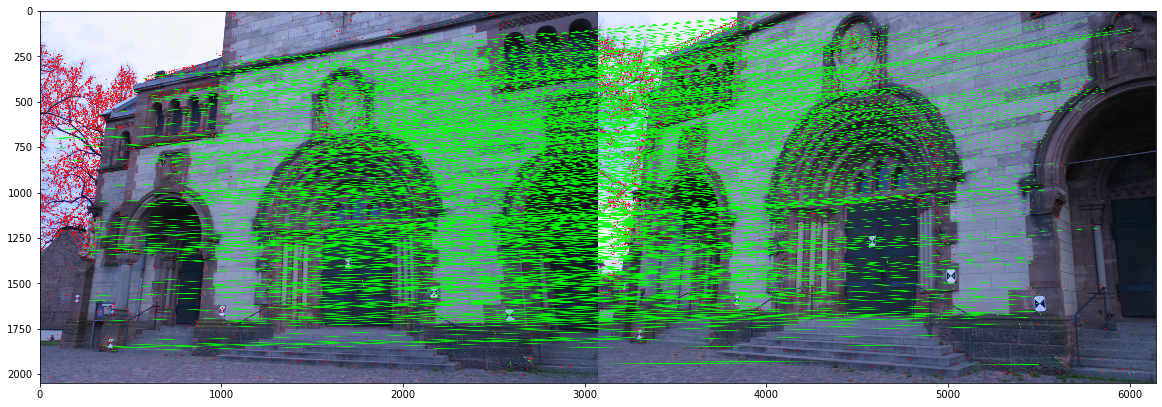

(<matplotlib.image.AxesImage at 0x7f5f263b31d0>, None)

In [8]:

sift = cv2.xfeatures2d.SIFT_create()
kps1, desc1 = sift.detectAndCompute(gray1, None)
kps2, desc2 = sift.detectAndCompute(gray2, None)
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)  

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(desc1,desc2,k=2)


matchesMask = [[0,0] for i in range(len(matches))]
good = []
imgPts1 = []
imgPts2 = []


for i,(m,n) in enumerate(matches):
    if m.distance < 0.6*n.distance:
        matchesMask[i]=[1,0]
        good.append(m)
        imgPts2.append(kps2[m.trainIdx].pt)
        imgPts1.append(kps1[m.queryIdx].pt)
print("matches: "+str(len(good)))

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(disp1,kps1,disp2,kps2,matches,None,**draw_params)
plt.figure(figsize = (20,20))
plt.imshow(img3,),plt.show()

In [9]:
#converting into np 32 type array
imgPts1 = np.int32(imgPts1)
imgPts2 = np.int32(imgPts2)
F, mask = cv2.findFundamentalMat(imgPts1,imgPts2,cv2.LMEDS)

#only returning points that have a mask
imgPts1 = imgPts1[mask.ravel()==1]
imgPts2 = imgPts2[mask.ravel()==1]

In [10]:
#Calculating the essential matrix

E = K.T.dot(F).dot(K)
R1,R2,t=cv2.decomposeEssentialMat(E)

t = t.reshape(3,1)

In [11]:
#Triangulation: to perform triangulation, we will first remove the effect of known caliberation matrix by normalizing the coordinates. 
#Initial step would be to convert the point coordinates to homogeneous coordinates and then normalize by  K^-1 P = [R|t]

#Homogeneous conversion


hom_img1= cv2.convertPointsToHomogeneous(imgPts1).reshape(-1,3)

hom_img2= cv2.convertPointsToHomogeneous(imgPts2).reshape(-1,3)

#Normalization

imgPts1_norm = K_inv.dot(hom_img1.T).T
imgPts2_norm = K_inv.dot(hom_img2.T).T

#as we need to convert it back from homogeneous for triangulation, we will convert back from homogeneous

imgPts1_norm = cv2.convertPointsFromHomogeneous(imgPts1_norm).reshape(-1,2)
imgPts2_norm = cv2.convertPointsFromHomogeneous(imgPts2_norm).reshape(-1,2)

intrinsic = np.hstack((np.eye(3), np.zeros((3, 1))))
extrinsic = np.hstack((R2, t.reshape(3, 1)))

imgPts_hom= cv2.triangulatePoints(intrinsic, extrinsic, imgPts1_norm.T, imgPts2_norm.T).T

#converting back from homogeneous coordinates
imgPts_3D=cv2.convertPointsFromHomogeneous(imgPts_hom).reshape(-1,3)

In [12]:
# Rodrigues formula converts a rotation matrix to a rotation vector or vice versa.
rot_vector, jacobian=cv2.Rodrigues(R2)
theta= np.sqrt(rot_vector[0]**2+rot_vector[1]**2+rot_vector[2]**2)

In [13]:
#Projects 3D points to an image plane.
output_points,_=cv2.projectPoints(imgPts_3D, rot_vector, t, K,None)

In [14]:
#Root Mean Square Error Calculation between the projected points and original points
np.mean(np.sqrt(np.sum((imgPts2-output_points.reshape(-1,2))**2,axis=-1)))

0.8103001220538613

In [15]:

# Storing the 3D points as a ply file. This can be visualized in meshlab or blender.
ply_3D = np.hstack([imgPts_3D.reshape(-1,3)])
ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    end_header
'''
with open('output.ply', 'w') as f:
    f.write(ply_header % dict(vert_num=len(ply_3D)))
    np.savetxt(f, ply_3D, '%f %f %f')
    